In [80]:
import numpy as np
import pandas as pd
import scipy
from scipy import spatial
import matplotlib.pyplot as plt

In [98]:
#read in data
x_train = np.genfromtxt("/Users/rebecca.peyser/Documents/Columbia_DSI/machinelearning/HW/Homework 3/hw3-data/boosting/X_train.csv", delimiter = ",")
y_train = np.genfromtxt("/Users/rebecca.peyser/Documents/Columbia_DSI/machinelearning/HW/Homework 3/hw3-data/boosting/y_train.csv", delimiter = ",")
x_test = np.genfromtxt("/Users/rebecca.peyser/Documents/Columbia_DSI/machinelearning/HW/Homework 3/hw3-data/boosting/X_test.csv", delimiter = ",")
y_test = np.genfromtxt("/Users/rebecca.peyser/Documents/Columbia_DSI/machinelearning/HW/Homework 3/hw3-data/boosting/y_test.csv", delimiter = ",")

In [171]:
def w_OLS(X_train, Y_train):
    X_train = np.concatenate((np.ones((len(X_train),1)), X_train), 1) #add dimension of 1's
    w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X_train), X_train)), np.transpose(X_train)), Y_train)
    return(w)

def predict_OLS(w, X_predict): #Xs are matrices
    X_predict = np.concatenate((np.ones((len(X_predict),1)), X_predict), 1) #add dimension of 1's
    prediction_vec = np.dot(X_predict, w)
    return(prediction_vec)

def bootstrap(size, weights, originalX, originalY):
    inds = np.random.choice(np.arange(len(originalX)), size = size, p = weights)
    return(originalX[inds,], originalY[inds], inds)  

def boosting_prediction_error(alphaxf_sum_for_fboost, true_y):
    predictions = np.zeros(alphaxf_sum_for_fboost.shape)
    predictions[alphaxf_sum_for_fboost > 0] = 1
    predictions[alphaxf_sum_for_fboost < 0] = -1
    error = np.subtract(predictions, true_y)
    error[error != 0] = 1
    error_rate = np.mean(error)
    return(error_rate)

In [221]:
#N for each bootstrap
B_size = len(x_train)

#record epsilon, alpha, and training and testing predictions at each iteration
epsilons = []
alphas = []
points_selected = [] #running list of points selected for bootstrapping
train_error = []
test_error = []

#initialize weights for boosting
weights = np.repeat(1/B_size, B_size) 
#initialize vector to hold running sum of alpha*predictions
sum_for_fboost_train = np.zeros(y_train.shape)
sum_for_fboost_test = np.zeros(y_test.shape)

#boost!
for t in np.arange(1500):
    #learn classifier on bootstrapped sample
    boot_x, boot_y, data_selected = bootstrap(B_size, weights, x_train, y_train)
    points_selected.extend(data_selected) #record data points selected by bootstrap
    w = w_OLS(boot_x, boot_y)
    
    #predict on training data
    y_predict_train = predict_OLS(w, x_train)
    y_predict_train = np.sign(y_predict_train)

    #y_predict_test[y_predict_test > 0] = 1
    #y_predict_test[y_predict_test < 0] = -1
    
    #find epsilon and alpha
    indicator = np.subtract(y_predict_train, y_train)
    indicator[indicator != 0] = 1
    epsilon = np.dot(weights, indicator)
    if epsilon > 0.5: #if epsilon is greater than 0.5, change sign of w and recalc
        w = -w
        y_predict_train = predict_OLS(w, x_train)
        #y_predict_train[y_predict_train > 0] = 1
        #y_predict_train[y_predict_train < 0] = -1
        y_predict_train = np.sign(y_predict_train)
        indicator = np.subtract(y_predict_train, y_train)
        indicator[indicator != 0] = 1
        epsilon = np.dot(weights, indicator) 
    alpha = 0.5*np.log((1-epsilon)/epsilon) 
    alphas.append(alpha) #record alpha
    epsilons.append(epsilon) #record epsilon
    
    #predict testing data (needs to move to here, after w is possibly modified)
    y_predict_test = predict_OLS(w, x_test)
    y_predict_test = np.sign(y_predict_test)
    
    #boosting training and testing predictions at iteration t
    sum_for_fboost_train = sum_for_fboost_train + alpha*y_predict_train
    sum_for_fboost_test = sum_for_fboost_test + alpha*y_predict_test
    
    #record train and test error for boosting classifier at each iteration
    train_error.append(boosting_prediction_error(sum_for_fboost_train, y_train))
    test_error.append(boosting_prediction_error(sum_for_fboost_test, y_test))

    #update weights
    weights = np.multiply(weights, np.exp(-alpha*np.multiply(y_train, y_predict_train))) #I'm supposed to calculate this over new y_predict_train after changing sign of w, right???
    weights = weights/np.sum(weights)

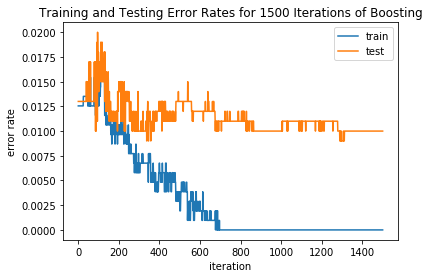

In [222]:
#plot training and testing error
t = np.linspace(1,1500,1500)
plt.plot(t, train_error, t, test_error)
plt.ylabel('error rate')
plt.xlabel('iteration')
plt.legend(['train', 'test'])
plt.title('Training and Testing Error Rates for 1500 Iterations of Boosting')
plt.show()

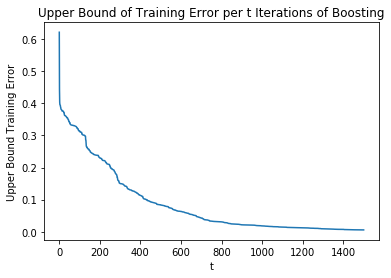

In [224]:
#calculate upper bound of training error
tmp = np.square(np.subtract(0.5,epsilons))
upper_bounds = np.exp(-2*np.cumsum(tmp))

#plot
t = np.linspace(1,1500,1500)
plt.plot(t, upper_bounds)
plt.title('Upper Bound of Training Error per t Iterations of Boosting')
plt.xlabel('t')
plt.ylabel('Upper Bound Training Error')
plt.show()

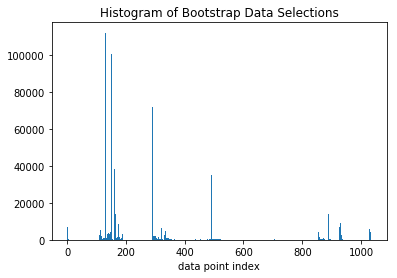

In [220]:
#plot histogram for the number of times each datapoint was sampled
plt.hist(points_selected, bins = len(x_train))
plt.xlabel('data point index')
plt.title('Histogram of Bootstrap Data Selections')
plt.show()

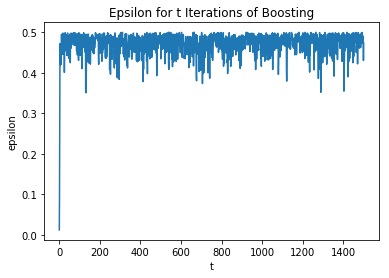

In [225]:
#plot epsilon
t = np.linspace(1,1500,1500)
plt.plot(t, epsilons)
plt.title('Epsilon for t Iterations of Boosting')
plt.xlabel('t')
plt.ylabel('epsilon')
plt.show()

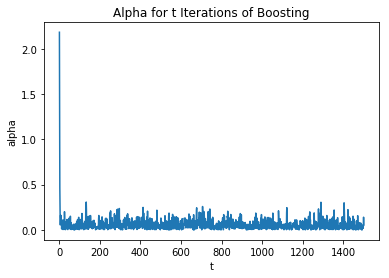

In [226]:
#plot alpha
t = np.linspace(1,1500,1500)
plt.plot(t, alphas)
plt.title('Alpha for t Iterations of Boosting')
plt.xlabel('t')
plt.ylabel('alpha')
plt.show()